In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Use seaborn's default style to make beautifull graphs

import pandas as pd
import numpy as np

import folium
from geopy.geocoders import Nominatim

In [17]:
emdat_data = pd.read_excel("data/public_emdat_incl_hist_2024-03-26.xlsx")
#emdat_data = pd.read_csv(f"updated_emdat_data.csv")

In [18]:
emdat_data.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

In [19]:
# If multiple countries are affected, each will have an entry linked to the same Dis No.
emdat_data["Country"].unique()

array(['United States of America', 'Jamaica', 'Japan', 'Türkiye', 'India',
       'Cabo Verde', 'Uganda', 'Belgium', 'Guatemala', 'Myanmar',
       'Martinique', 'Saint Vincent and the Grenadines', 'Soviet Union',
       'China', 'Canada', 'France', 'Comoros', 'Israel',
       'Iran (Islamic Republic of)', 'Niger', 'Bangladesh',
       'Taiwan (Province of China)', 'Greece', 'Italy', 'Philippines',
       'Albania', 'Colombia', 'Chile',
       'China, Hong Kong Special Administrative Region',
       'United Kingdom of Great Britain and Northern Ireland', 'Germany',
       'Romania', 'Indonesia', 'Mexico', 'Haiti', 'Morocco', 'Portugal',
       'Pakistan', 'Costa Rica', 'Algeria', 'Burkina Faso', 'Gambia',
       'Guinea-Bissau', 'Mali', 'Mauritania', 'Senegal', 'Chad',
       'Kazakhstan', 'Spain', 'Peru', 'Tokelau', 'Belarus', 'Bulgaria',
       'Netherlands (Kingdom of the)', 'Denmark', 'Puerto Rico',
       'New Zealand', 'Anguilla', 'Germany Federal Republic', 'Argentina',
       '

In [20]:
emdat_data["Subregion"].unique() 

array(['Northern America', 'Latin America and the Caribbean',
       'Eastern Asia', 'Western Asia', 'Southern Asia',
       'Sub-Saharan Africa', 'Western Europe', 'South-eastern Asia',
       'Eastern Europe', 'Southern Europe', 'Northern Europe',
       'Northern Africa', 'Central Asia', 'Polynesia',
       'Australia and New Zealand', 'Melanesia', 'Micronesia'],
      dtype=object)

In [21]:
emdat_data["Region"].unique()

array(['Americas', 'Asia', 'Africa', 'Europe', 'Oceania'], dtype=object)

In [22]:
emdat_data["Location"] , len(emdat_data["Location"].unique())

(0                                        Galveston (Texas)
 1                                 Hoboken, New York, Piers
 2                                              Saint James
 3                                                    Porus
 4                                                      NaN
                                ...                        
 26438                                                Dakha
 26439                                                  NaN
 26440              Between Santa Rosa de Copan and Gracias
 26441                                      Niéna-Koumantou
 26442    Boyaca, Cordoba, Cundinamarca, Huila, Santande...
 Name: Location, Length: 26443, dtype: object,
 20361)

Text(0.5, 1.0, 'Percentage of missing values in each column')

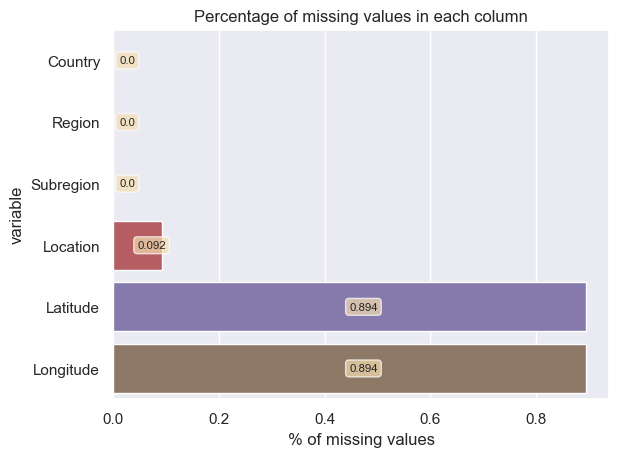

In [23]:
columns = ["Country","Region","Subregion","Location","Latitude","Longitude"]

fig, ax = plt.subplots()
sns.barplot(pd.DataFrame(emdat_data[columns].isna().mean()).reset_index().rename(columns={"index":"variable", 0:"% of missing values"}), y="variable", x="% of missing values", ax=ax, hue="variable", legend=False)
for i in ax.containers:
    ax.bar_label(
        i,
        fmt="{:.3}",
        label_type="center",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7),
        padding=10,
        fontsize="x-small",
    )
# set title
ax.set_title("Percentage of missing values in each column")

We almost don't have longitude and latitulde information, so start by using the disasters that have it
Then use locations columns, to obtain that info
Then if neither location use the country information with location at the center

Good idea to already preprocces all that data before, like add it to a our version of the data, to avoid the need to run when loading the page

In [43]:
# Function to geocode location names to latitude and longitude
def geocode_location(location,geolocator,country=None):
    try:
        print(location)
        if country:
            query = f"{location}, {country}"
        else:
            query = f"{location}"
        location = geolocator.geocode(query)

        if location:
            print(f"Geocoded {query} to {location.latitude}, {location.longitude}")
            return location.latitude, location.longitude
        else:
            print(f"Could not geocode {location}")
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {str(e)}")
        return None, None

In [44]:
# Check the number of missing locations of the cvs file
data = pd.read_csv(f"updated_emdat_data.csv")

missing_coords = data[data['Latitude'].isna() | data['Longitude'].isna()]
total_missing = len(missing_coords)
print(f"Total missing locations to geocode: {total_missing}")

Total missing locations to geocode: 12508


In [45]:
# Initialize a geocoder
geolocator = Nominatim(user_agent="my_geocoder")

# Apply geocoding to locations with missing latitude and longitude
missing_coords = data[data['Latitude'].isna() | data['Longitude'].isna()]
total_missing = len(missing_coords)
print(f"Total missing locations to geocode: {total_missing}")

# Reset progress counter
progress_counter = 0

# Save interval
save_interval = 1000
save_counter = 0

# Apply geocoding and track progress
for index, row in missing_coords.iterrows():

    # Geocode location
    latitude, longitude = geocode_location(row['Location'], geolocator)

    # Update latitude and longitude in DataFrame
    missing_coords.at[index, 'Latitude'] = latitude
    missing_coords.at[index, 'Longitude'] = longitude

    # Update progress
    progress_counter += 1
    print(f"Progress: {progress_counter}/{total_missing} ({(progress_counter/total_missing)*100:.2f}%), Info get: {latitude}, {longitude}")

    # Check if it's time to save the data
    if progress_counter % save_interval == 0:
        print("Saving progress...")
        # Concatenate with existing data and save to CSV
        pd.concat([data.drop(missing_coords.index), missing_coords]).to_csv(f'updated_emdat_data_{save_counter}.csv', index=False)

        # Increment save counter
        save_counter += 1

# Save the final updated data to a new CSV file
final_data = pd.concat([data.drop(missing_coords.index), missing_coords])
final_data.to_csv('updated_emdat_data_B.csv', index=False)

Total missing locations to geocode: 12508
Hoboken, New York, Piers
Could not geocode None
Progress: 1/12508 (0.01%), Info get: None, None
Tahoua area
Could not geocode None
Progress: 2/12508 (0.02%), Info get: None, None
New York harbor, East river
Could not geocode None
Progress: 3/12508 (0.02%), Info get: None, None
Spence's Bridge, British Columbia
Could not geocode None
Progress: 4/12508 (0.03%), Info get: None, None
Mississippi, Alabama, Pensacola
Could not geocode None
Progress: 5/12508 (0.04%), Info get: None, None
Gascognes Gulf
Could not geocode None
Progress: 6/12508 (0.05%), Info get: None, None
Birni N'konni, Madoua, Tahoua
Could not geocode None
Progress: 7/12508 (0.06%), Info get: None, None
Chelsea, Massachussetts
Could not geocode None
Progress: 8/12508 (0.06%), Info get: None, None
Nadu Khas
Could not geocode None
Progress: 9/12508 (0.07%), Info get: None, None
Grand Isle (Lousiana)
Could not geocode None
Progress: 10/12508 (0.08%), Info get: None, None
Cul de Sac,Leog

KeyboardInterrupt: 

In [ ]:
"""# Create a map centered around a specific location
m = folium.Map(location=[emdat_data['Latitude'].mean(), emdat_data['Longitude'].mean()], zoom_start=5)

# Add markers for each disaster location
for index, row in emdat_data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Location']).add_to(m)

# Save the map to an HTML file
m.save('disaster_map.html')
"""